# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we study the importance of the features in the decision trees algorithms and their Shapley values.

In [1]:
%load_ext autoreload
%autoreload 2

## Load the Datasets

We can now load the test sets used in the previous ML analysis:

In [2]:
import pandas as pd

test = pd.read_csv('./data/test.csv')

## Load the Models

We then load the training models of the random forests and the gradient boosted trees:

In [3]:
import joblib

rnd_for = joblib.load('./models/rf_lgbmregressor.pkl')
grd_bst = joblib.load('./models/gbdt_lgbmregressor.pkl')

## Shapley Values and Variable Ranking

Using the definition of the Shapley values we study the variable ranking and contribution of the features:

In [4]:
import shap
import os
import joblib

# create the directory
os.makedirs('./shap', exist_ok=True)

# import the "explainers" and save the values
rnd_for_exp = shap.TreeExplainer(rnd_for, feature_perturbation='tree_path_dependent')
grd_bst_exp = shap.TreeExplainer(grd_bst, feature_perturbation='tree_path_dependent')

# extract the Shapley values
rnd_for_shap = rnd_for_exp.shap_values(test)
grd_bst_shap = grd_bst_exp.shap_values(test)

joblib.dump(rnd_for_shap, './shap/rnd_for_shap.pkl')
joblib.dump(grd_bst_shap, './shap/grd_bst_shap.pkl')

rnd_for_int_shap = rnd_for_exp.shap_interaction_values(test)
grd_bst_int_shap = grd_bst_exp.shap_interaction_values(test)

joblib.dump(rnd_for_int_shap, './shap/rnd_for_int_shap.pkl')
joblib.dump(grd_bst_int_shap, './shap/grd_bst_int_shap.pkl')

# compute the feature importance
rnd_for_imp = rnd_for.feature_importances_.reshape(-1,)
grd_bst_imp = grd_bst.feature_importances_.reshape(-1,)

joblib.dump(rnd_for_imp, './shap/rnd_for_imp.pkl')
joblib.dump(grd_bst_imp, './shap/grd_bst_imp.pkl')

# finally store the names of the features
features = list(test.columns)

joblib.dump(features, './shap/feature_list.pkl')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


['./shap/feature_list.pkl']

We can therefore show the Shapley values in plots. We show the importance of the features as computed from the decision trees (i.e. the LightGBM trees), the mean Shapley values for each feature and the interaction Shapley values for a randomly chosen sample in the test set.

We start from the RF:

In [5]:
SHAPLEY  = './shap/rnd_for_shap.pkl'
INTERACT = './shap/rnd_for_int_shap.pkl'
RANK     = './shap/rnd_for_imp.pkl'
FEAT     = './shap/feature_list.pkl'
OUTPUT   = 'rnd_for'

!python3 ./scripts/shap.py --features {FEAT} \
                           --shapley {SHAPLEY} \
                           --inter {INTERACT} \
                           --rank {RANK} \
                           --output {OUTPUT}

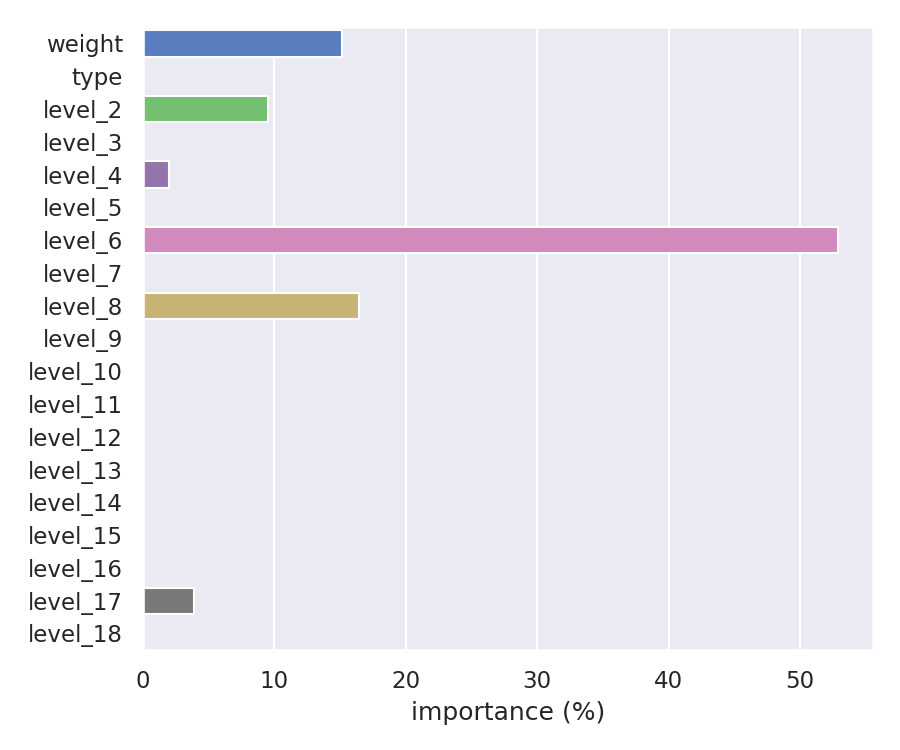

In [6]:
from IPython.display import Image
Image('./img/{}_rank.png'.format(OUTPUT), width=480)

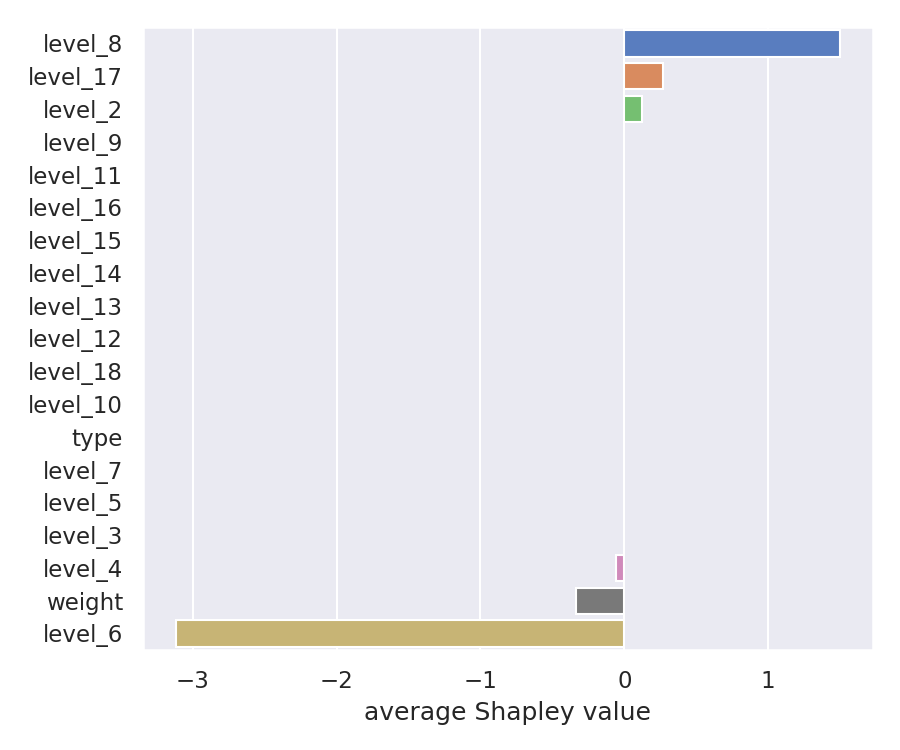

In [7]:
from IPython.display import Image
Image('./img/{}_shap.png'.format(OUTPUT), width=480)

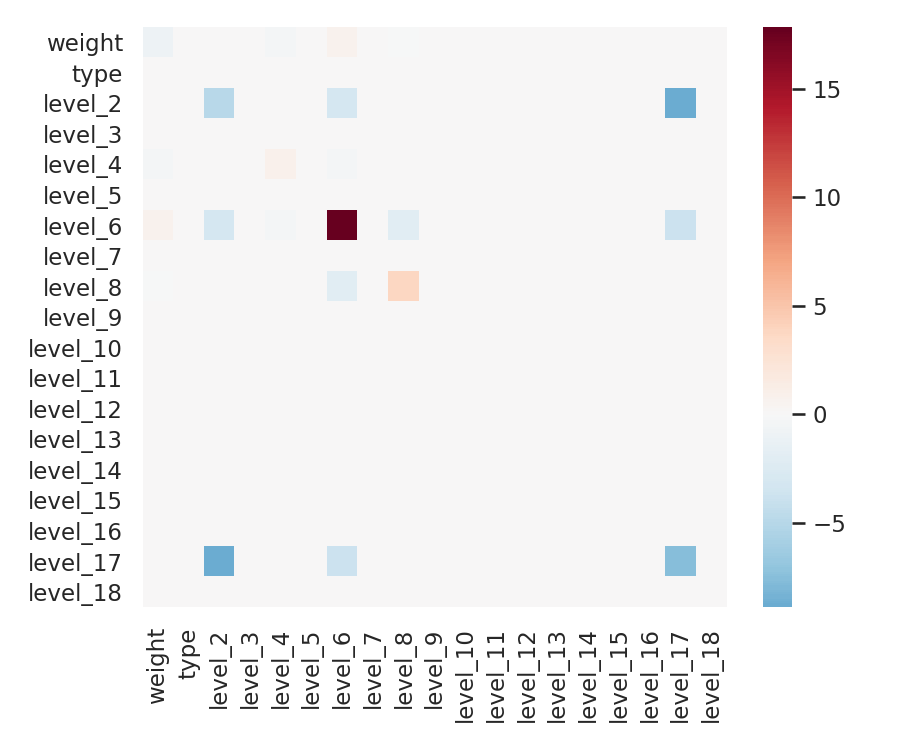

In [8]:
from IPython.display import Image
Image('./img/{}_shap_int.png'.format(OUTPUT), width=480)

We then move to the GBDT:

In [9]:
SHAPLEY  = './shap/grd_bst_shap.pkl'
INTERACT = './shap/grd_bst_int_shap.pkl'
RANK     = './shap/grd_bst_imp.pkl'
FEAT     = './shap/feature_list.pkl'
OUTPUT   = 'grd_bst'

!python3 ./scripts/shap.py --features {FEAT} \
                           --shapley {SHAPLEY} \
                           --inter {INTERACT} \
                           --rank {RANK} \
                           --output {OUTPUT}

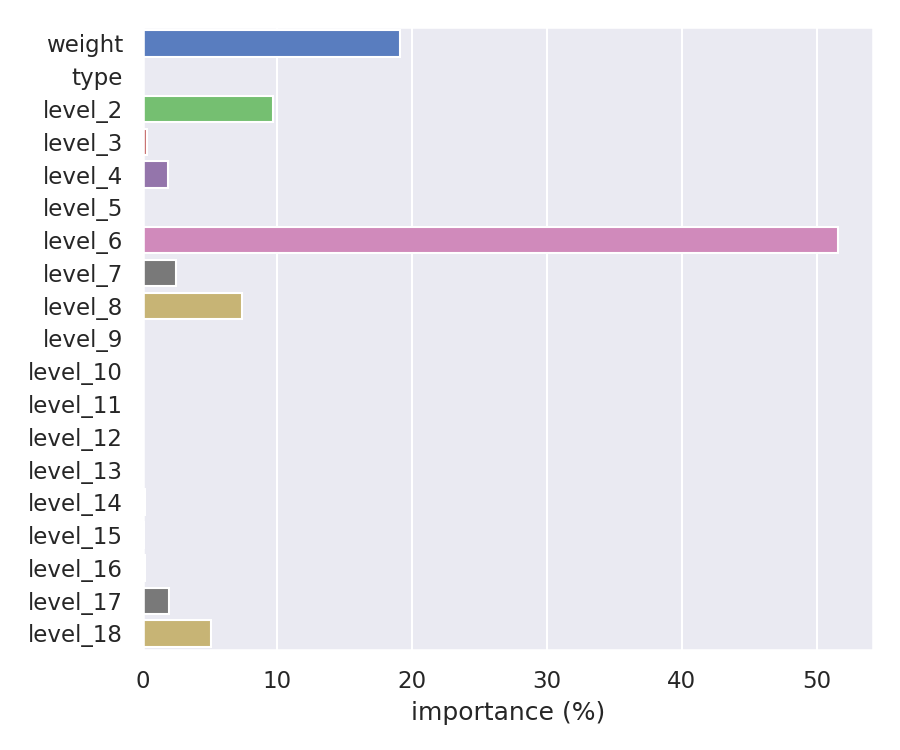

In [10]:
from IPython.display import Image
Image('./img/{}_rank.png'.format(OUTPUT), width=480)

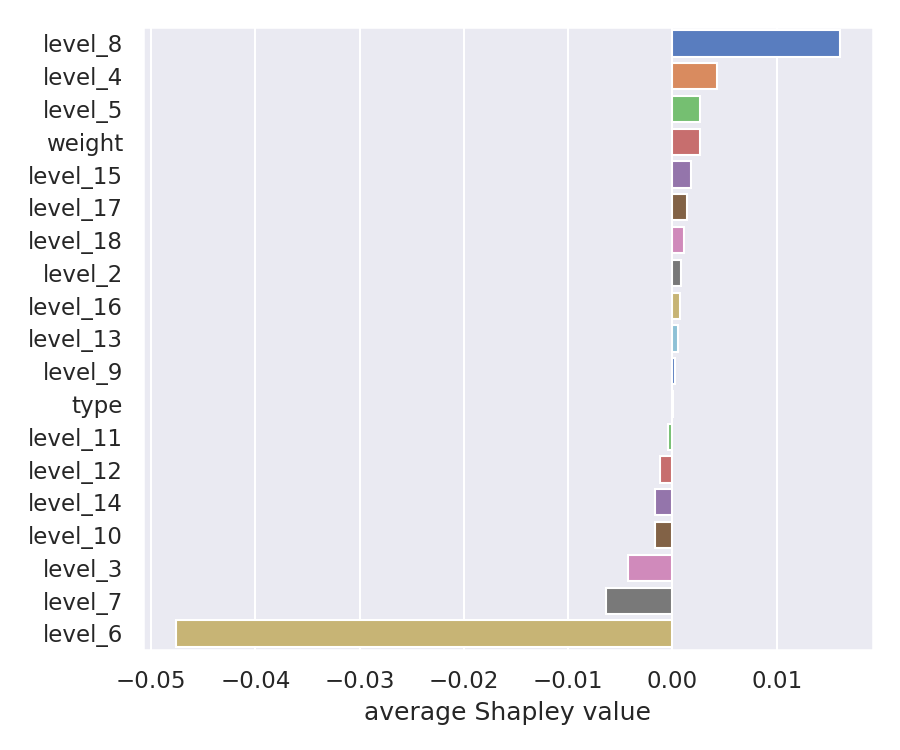

In [11]:
from IPython.display import Image
Image('./img/{}_shap.png'.format(OUTPUT), width=480)

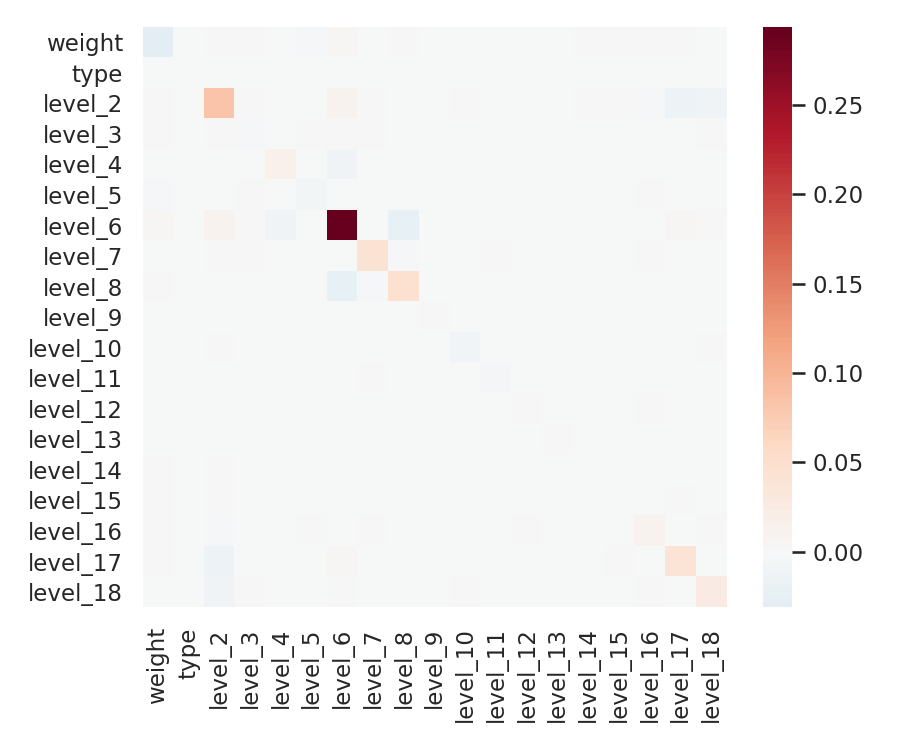

In [12]:
from IPython.display import Image
Image('./img/{}_shap_int.png'.format(OUTPUT), width=480)

## Analysis of the Feature Importance

Since there are variables which have a large impact on the results, we study what happens when removing them: we train a GBDT for each new dataset and study its behaviour.

### Removing the Most Important Feature

In [13]:
import pandas as pd

# load the datasets
train = pd.read_csv('./data/train.csv')
val   = pd.read_csv('./data/val.csv')
test  = pd.read_csv('./data/test.csv')

# remove the features
col = ['level_6']
train = train.drop(columns=col)
val   = val.drop(columns=col)
test  = test.drop(columns=col)

# join the validation and test sets (do not use optimisation and divide 80/20)
new_test = pd.concat([val, test])

# temporarily save the new datasets
train.to_csv('./data/train_tmp.csv', index=False)
new_test.to_csv('./data/test_tmp.csv', index=False)

# load the labels (join validation and test)
lab_val = pd.read_csv('./data/lab_val.csv')
lab_test = pd.read_csv('./data/lab_test.csv')

new_lab_test = pd.concat([lab_val, lab_test])

new_lab_test.to_csv('./data/lab_test_tmp.csv', index=False)

In [14]:
TRAIN = './data/train_tmp.csv'
TEST  = './data/test_tmp.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_TEST  = './data/lab_test_tmp.csv'

!cp ./models/gbdt_lgbmregressor.pkl ./models/gbdt_lgbmregressor_shap.pkl
ESTIMATOR = './models/gbdt_lgbmregressor_shap.pkl'

OUTPUT = 'gbdt_no6'

!python3 ./scripts/scikit-train.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT}

LGBMRegressor trained in 0.165 seconds.
LGBMRegressor predicted in 0.003 seconds.


In [15]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
gbdt_no6,127,0.000906,-0.000052,0.001864,0.030102,0.015068,0.998174


In [16]:
import joblib
import pandas as pd

grd_bst = joblib.load(ESTIMATOR)
test    = pd.read_csv('./data/test_tmp.csv')

# import the "explainers" and save the values
grd_bst_exp = shap.TreeExplainer(grd_bst, feature_perturbation='tree_path_dependent')

# extract the Shapley values
grd_bst_shap = grd_bst_exp.shap_values(test)
joblib.dump(grd_bst_shap, './shap/grd_bst_no6_shap.pkl')

rgrd_bst_int_shap = grd_bst_exp.shap_interaction_values(test)
joblib.dump(grd_bst_int_shap, './shap/grd_bst_no6_int_shap.pkl')

# compute the feature importance
grd_bst_imp = grd_bst.feature_importances_.reshape(-1,)
joblib.dump(grd_bst_imp, './shap/grd_bst_no6_imp.pkl')

# finally store the names of the features
features = list(test.columns)
joblib.dump(features, './shap/feature_no6_list.pkl')

# compute and display the Shapley values
SHAPLEY  = './shap/grd_bst_no6_shap.pkl'
INTERACT = './shap/grd_bst_no6_int_shap.pkl'
RANK     = './shap/grd_bst_no6_imp.pkl'
FEAT     = './shap/feature_no6_list.pkl'
OUTPUT   = 'grd_bst'

!python3 ./scripts/shap.py --features {FEAT} \
                           --shapley {SHAPLEY} \
                           --inter {INTERACT} \
                           --rank {RANK} \
                           --output {OUTPUT}

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


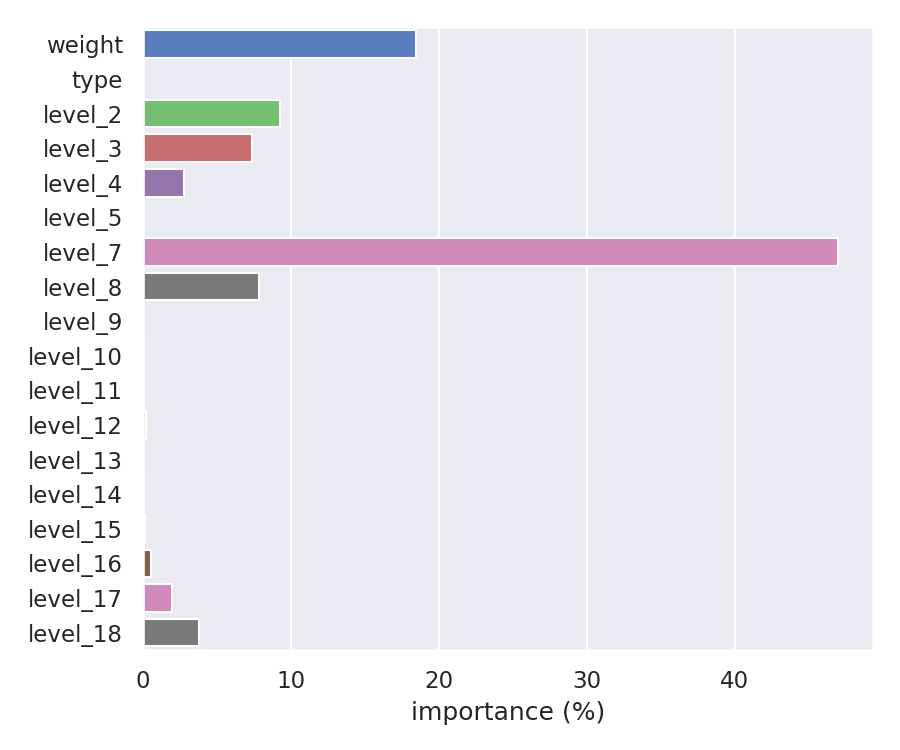

In [17]:
from IPython.display import Image
Image('./img/{}_rank.png'.format(OUTPUT), width=480)

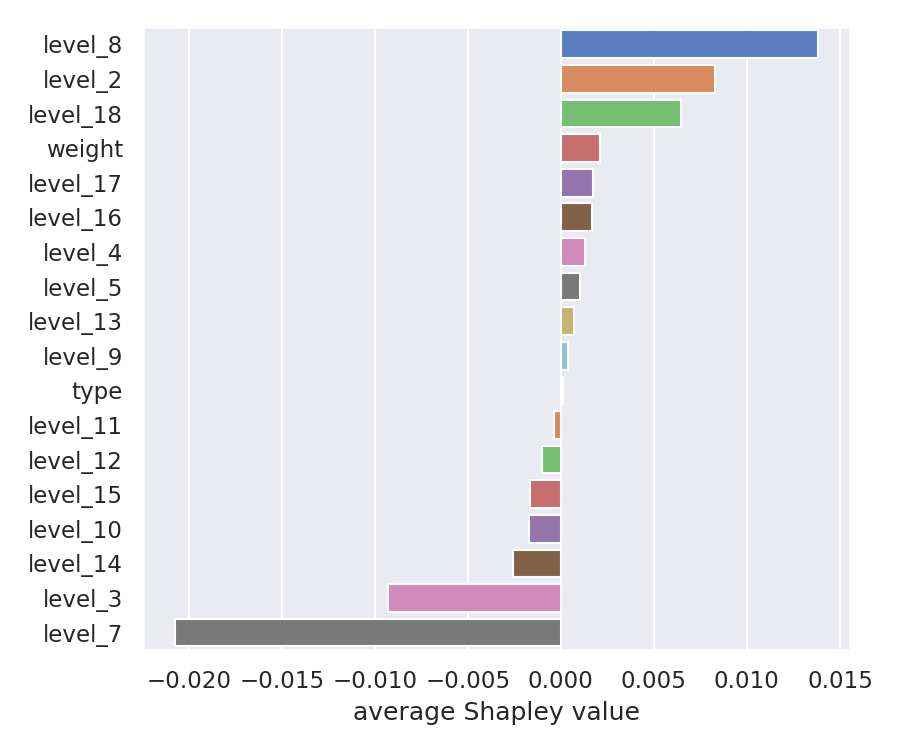

In [18]:
from IPython.display import Image
Image('./img/{}_shap.png'.format(OUTPUT), width=480)

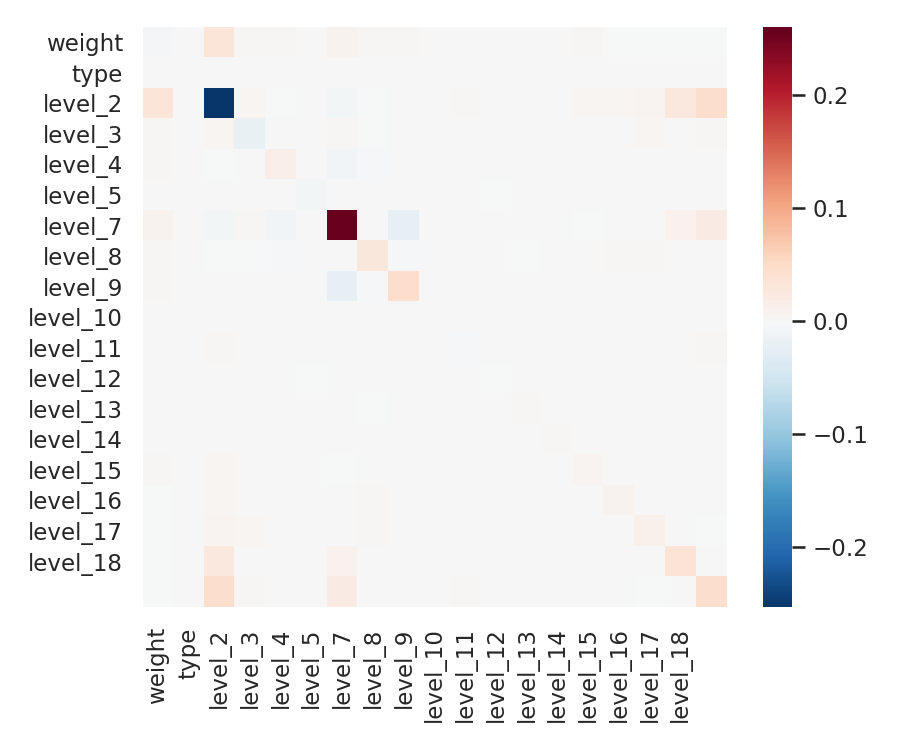

In [19]:
from IPython.display import Image
Image('./img/{}_shap_int.png'.format(OUTPUT), width=480)

### Removing Low Truncation Levels

In [20]:
import pandas as pd

# load the datasets
train = pd.read_csv('./data/train.csv')
val   = pd.read_csv('./data/val.csv')
test  = pd.read_csv('./data/test.csv')

# remove the features
col = ['level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7']
train = train.drop(columns=col)
val   = val.drop(columns=col)
test  = test.drop(columns=col)

# join the validation and test sets (do not use optimisation and divide 80/20)
new_test = pd.concat([val, test])

# temporarily save the new datasets
train.to_csv('./data/train_tmp.csv', index=False)
new_test.to_csv('./data/test_tmp.csv', index=False)

# load the labels (join validation and test)
lab_val = pd.read_csv('./data/lab_val.csv')
lab_test = pd.read_csv('./data/lab_test.csv')

new_lab_test = pd.concat([lab_val, lab_test])

new_lab_test.to_csv('./data/lab_test_tmp.csv', index=False)

In [21]:
TRAIN = './data/train_tmp.csv'
TEST  = './data/test_tmp.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_TEST  = './data/lab_test_tmp.csv'

!cp ./models/gbdt_lgbmregressor.pkl ./models/gbdt_lgbmregressor_shap.pkl
ESTIMATOR = './models/gbdt_lgbmregressor_shap.pkl'

OUTPUT = 'gbdt_no6'

!python3 ./scripts/scikit-train.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT}

LGBMRegressor trained in 0.137 seconds.
LGBMRegressor predicted in 0.002 seconds.


In [22]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
gbdt_no6,132,0.003687,0.000853,0.00652,0.060717,0.028379,0.992571


In [23]:
import joblib
import pandas as pd

grd_bst = joblib.load(ESTIMATOR)
test    = pd.read_csv('./data/test_tmp.csv')

# import the "explainers" and save the values
grd_bst_exp = shap.TreeExplainer(grd_bst, feature_perturbation='tree_path_dependent')

# extract the Shapley values
grd_bst_shap = grd_bst_exp.shap_values(test)
joblib.dump(grd_bst_shap, './shap/grd_bst_no6_shap.pkl')

rgrd_bst_int_shap = grd_bst_exp.shap_interaction_values(test)
joblib.dump(grd_bst_int_shap, './shap/grd_bst_no6_int_shap.pkl')

# compute the feature importance
grd_bst_imp = grd_bst.feature_importances_.reshape(-1,)
joblib.dump(grd_bst_imp, './shap/grd_bst_no6_imp.pkl')

# finally store the names of the features
features = list(test.columns)
joblib.dump(features, './shap/feature_no6_list.pkl')

# compute and display the Shapley values
SHAPLEY  = './shap/grd_bst_no6_shap.pkl'
INTERACT = './shap/grd_bst_no6_int_shap.pkl'
RANK     = './shap/grd_bst_no6_imp.pkl'
FEAT     = './shap/feature_no6_list.pkl'
OUTPUT   = 'grd_bst'

!python3 ./scripts/shap.py --features {FEAT} \
                           --shapley {SHAPLEY} \
                           --inter {INTERACT} \
                           --rank {RANK} \
                           --output {OUTPUT}

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


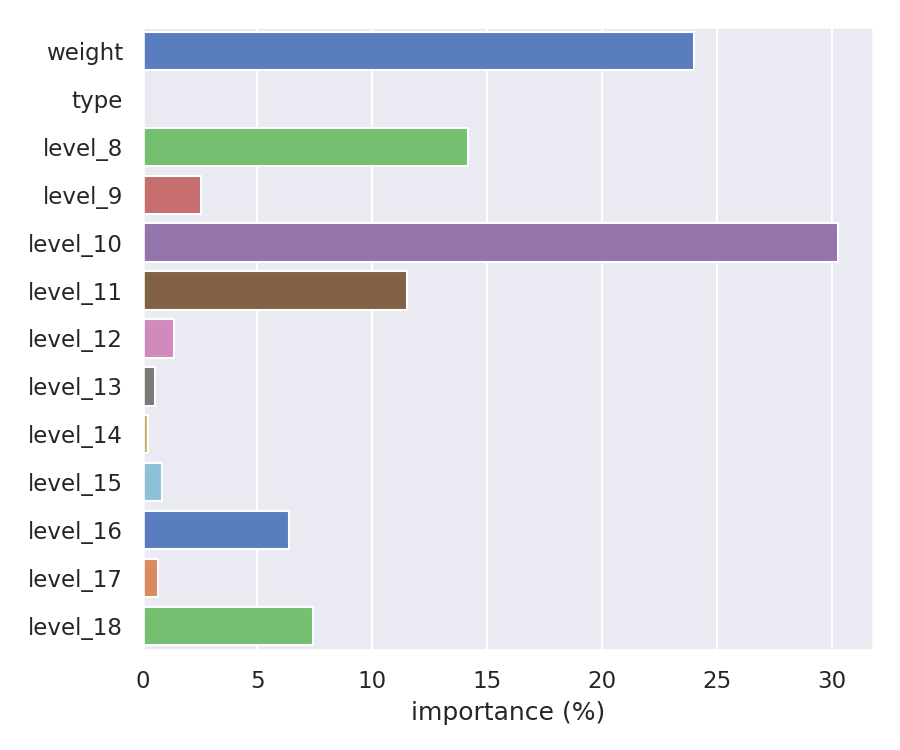

In [24]:
from IPython.display import Image
Image('./img/{}_rank.png'.format(OUTPUT), width=480)

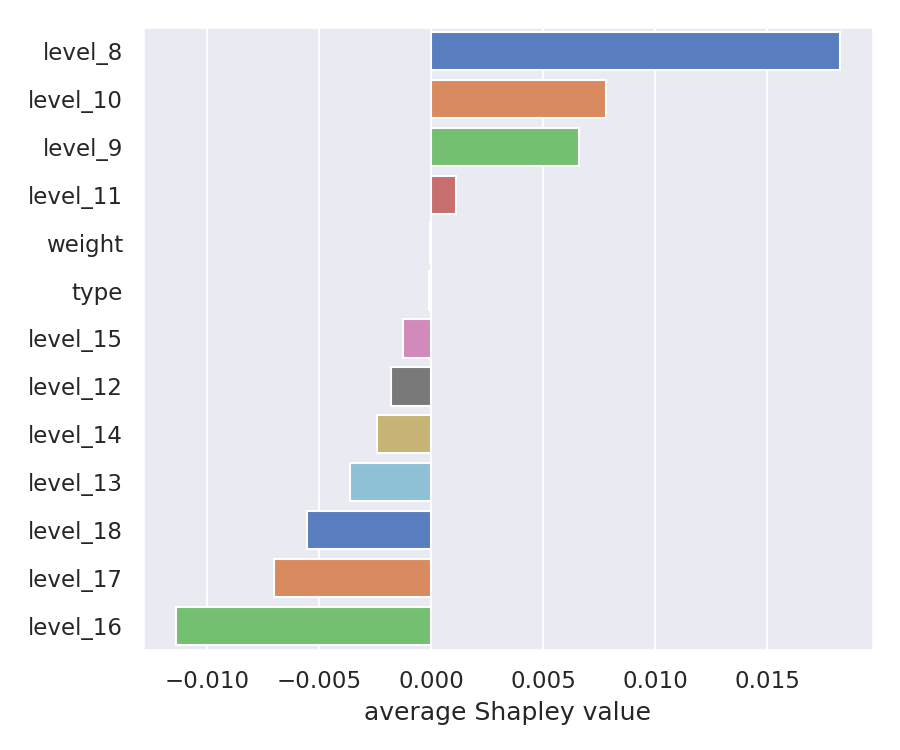

In [25]:
from IPython.display import Image
Image('./img/{}_shap.png'.format(OUTPUT), width=480)

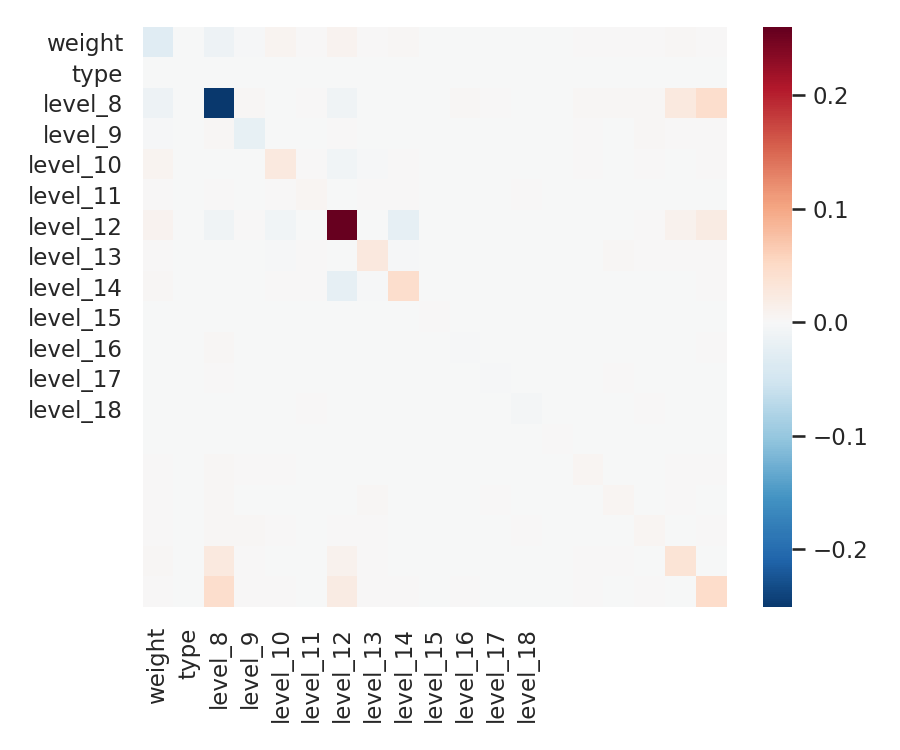

In [26]:
from IPython.display import Image
Image('./img/{}_shap_int.png'.format(OUTPUT), width=480)

### Removing the High Truncation Levels

In [27]:
import pandas as pd

# load the datasets
train = pd.read_csv('./data/train.csv')
val   = pd.read_csv('./data/val.csv')
test  = pd.read_csv('./data/test.csv')

# remove the features
col = ['level_13', 'level_14', 'level_15', 'level_16', 'level_17', 'level_18']
train = train.drop(columns=col)
val   = val.drop(columns=col)
test  = test.drop(columns=col)

# join the validation and test sets (do not use optimisation and divide 80/20)
new_test = pd.concat([val, test])

# temporarily save the new datasets
train.to_csv('./data/train_tmp.csv', index=False)
new_test.to_csv('./data/test_tmp.csv', index=False)

# load the labels (join validation and test)
lab_val = pd.read_csv('./data/lab_val.csv')
lab_test = pd.read_csv('./data/lab_test.csv')

new_lab_test = pd.concat([lab_val, lab_test])

new_lab_test.to_csv('./data/lab_test_tmp.csv', index=False)

In [28]:
TRAIN = './data/train_tmp.csv'
TEST  = './data/test_tmp.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_TEST  = './data/lab_test_tmp.csv'

!cp ./models/gbdt_lgbmregressor.pkl ./models/gbdt_lgbmregressor_shap.pkl
ESTIMATOR = './models/gbdt_lgbmregressor_shap.pkl'

OUTPUT = 'gbdt_no6'

!python3 ./scripts/scikit-train.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT}

LGBMRegressor trained in 0.124 seconds.
LGBMRegressor predicted in 0.002 seconds.


In [29]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
gbdt_no6,132,0.000638,0.000298,0.000978,0.025261,0.014984,0.998714


In [30]:
import joblib
import pandas as pd

grd_bst = joblib.load(ESTIMATOR)
test    = pd.read_csv('./data/test_tmp.csv')

# import the "explainers" and save the values
grd_bst_exp = shap.TreeExplainer(grd_bst, feature_perturbation='tree_path_dependent')

# extract the Shapley values
grd_bst_shap = grd_bst_exp.shap_values(test)
joblib.dump(grd_bst_shap, './shap/grd_bst_no6_shap.pkl')

rgrd_bst_int_shap = grd_bst_exp.shap_interaction_values(test)
joblib.dump(grd_bst_int_shap, './shap/grd_bst_no6_int_shap.pkl')

# compute the feature importance
grd_bst_imp = grd_bst.feature_importances_.reshape(-1,)
joblib.dump(grd_bst_imp, './shap/grd_bst_no6_imp.pkl')

# finally store the names of the features
features = list(test.columns)
joblib.dump(features, './shap/feature_no6_list.pkl')

# compute and display the Shapley values
SHAPLEY  = './shap/grd_bst_no6_shap.pkl'
INTERACT = './shap/grd_bst_no6_int_shap.pkl'
RANK     = './shap/grd_bst_no6_imp.pkl'
FEAT     = './shap/feature_no6_list.pkl'
OUTPUT   = 'grd_bst'

!python3 ./scripts/shap.py --features {FEAT} \
                           --shapley {SHAPLEY} \
                           --inter {INTERACT} \
                           --rank {RANK} \
                           --output {OUTPUT}

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


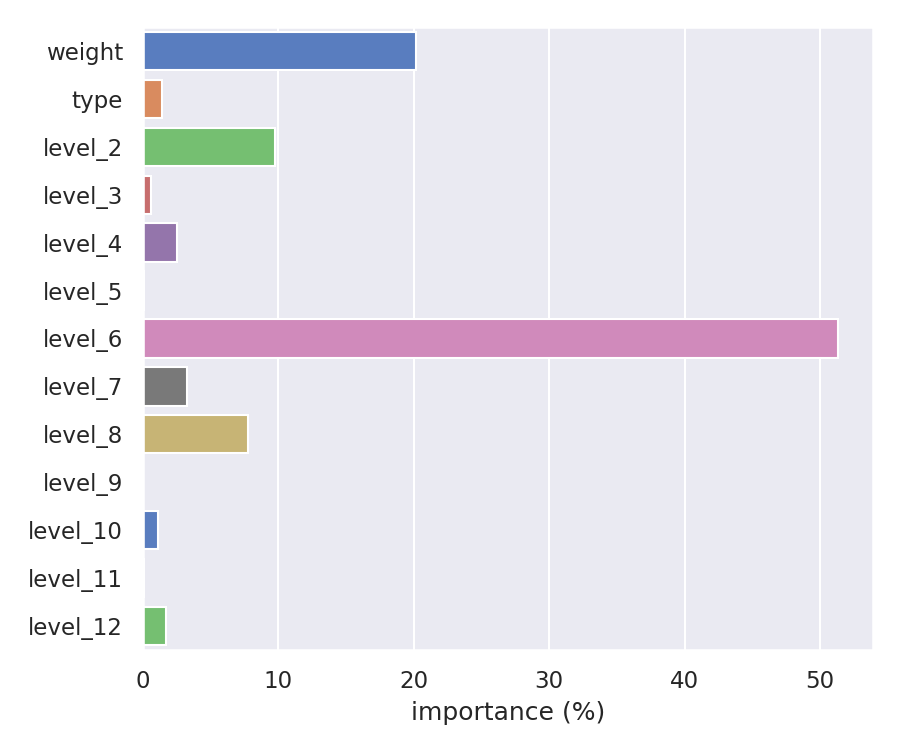

In [31]:
from IPython.display import Image
Image('./img/{}_rank.png'.format(OUTPUT), width=480)

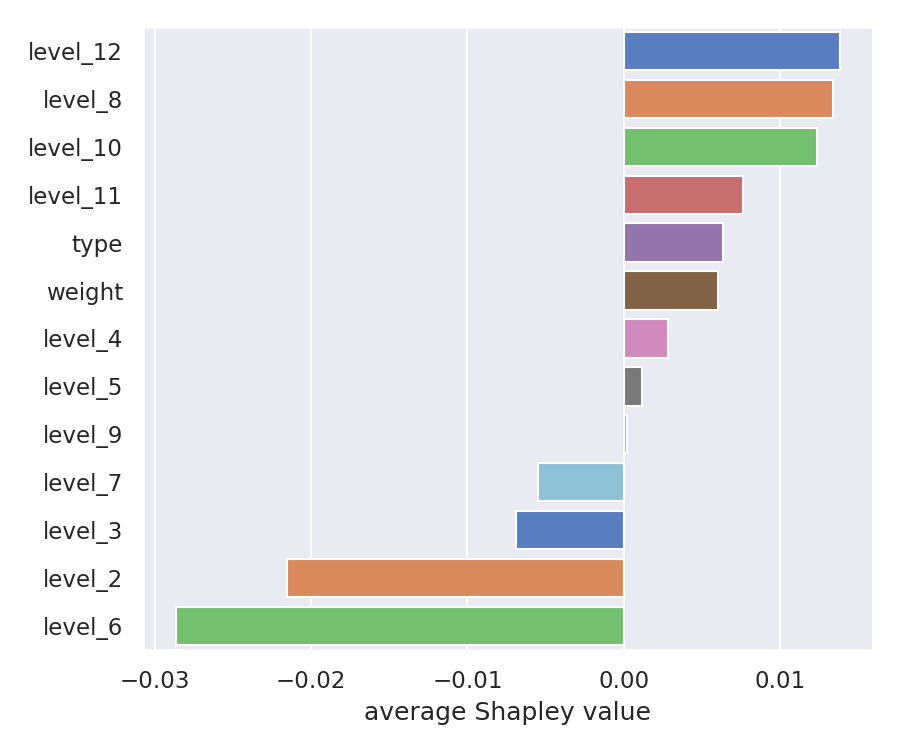

In [32]:
from IPython.display import Image
Image('./img/{}_shap.png'.format(OUTPUT), width=480)

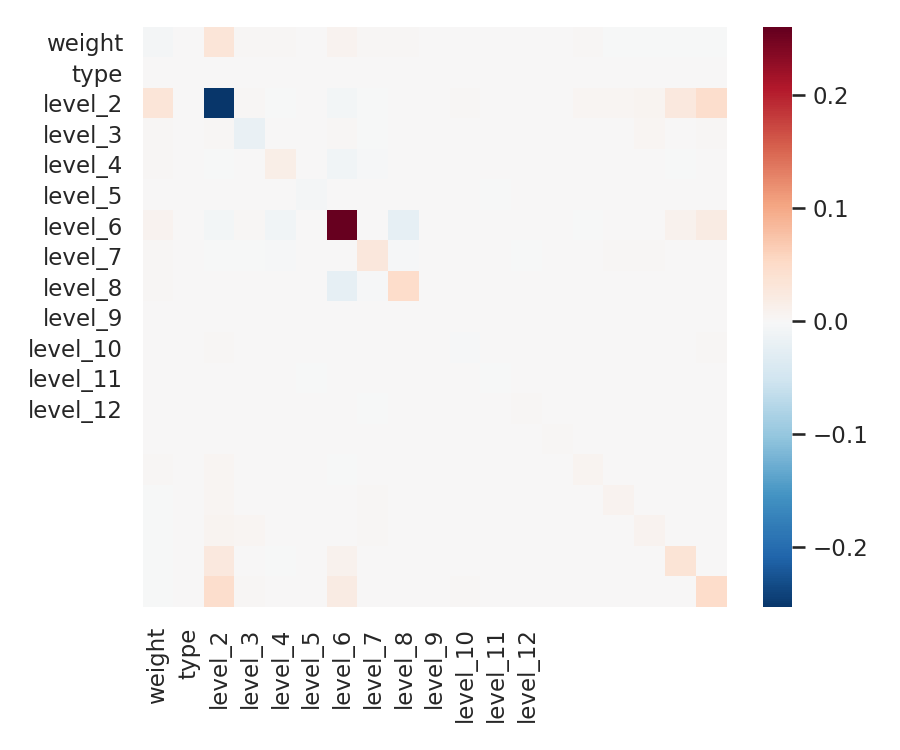

In [33]:
from IPython.display import Image
Image('./img/{}_shap_int.png'.format(OUTPUT), width=480)

### Removing the Central Truncation Levels

In [34]:
import pandas as pd

# load the datasets
train = pd.read_csv('./data/train.csv')
val   = pd.read_csv('./data/val.csv')
test  = pd.read_csv('./data/test.csv')

# remove the features
col = ['level_7', 'level_8', 'level_9', 'level_10', 'level_11', 'level_12']
train = train.drop(columns=col)
val   = val.drop(columns=col)
test  = test.drop(columns=col)

# join the validation and test sets (do not use optimisation and divide 80/20)
new_test = pd.concat([val, test])

# temporarily save the new datasets
train.to_csv('./data/train_tmp.csv', index=False)
new_test.to_csv('./data/test_tmp.csv', index=False)

# load the labels (join validation and test)
lab_val = pd.read_csv('./data/lab_val.csv')
lab_test = pd.read_csv('./data/lab_test.csv')

new_lab_test = pd.concat([lab_val, lab_test])

new_lab_test.to_csv('./data/lab_test_tmp.csv', index=False)

In [35]:
TRAIN = './data/train_tmp.csv'
TEST  = './data/test_tmp.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_TEST  = './data/lab_test_tmp.csv'

!cp ./models/gbdt_lgbmregressor.pkl ./models/gbdt_lgbmregressor_shap.pkl
ESTIMATOR = './models/gbdt_lgbmregressor_shap.pkl'

OUTPUT = 'gbdt_no6'

!python3 ./scripts/scikit-train.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT}

LGBMRegressor trained in 0.117 seconds.
LGBMRegressor predicted in 0.002 seconds.


In [36]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
gbdt_no6,132,0.00055,0.000039,0.001062,0.023458,0.013255,0.998891


In [37]:
import joblib
import pandas as pd

grd_bst = joblib.load(ESTIMATOR)
test    = pd.read_csv('./data/test_tmp.csv')

# import the "explainers" and save the values
grd_bst_exp = shap.TreeExplainer(grd_bst, feature_perturbation='tree_path_dependent')

# extract the Shapley values
grd_bst_shap = grd_bst_exp.shap_values(test)
joblib.dump(grd_bst_shap, './shap/grd_bst_no6_shap.pkl')

rgrd_bst_int_shap = grd_bst_exp.shap_interaction_values(test)
joblib.dump(grd_bst_int_shap, './shap/grd_bst_no6_int_shap.pkl')

# compute the feature importance
grd_bst_imp = grd_bst.feature_importances_.reshape(-1,)
joblib.dump(grd_bst_imp, './shap/grd_bst_no6_imp.pkl')

# finally store the names of the features
features = list(test.columns)
joblib.dump(features, './shap/feature_no6_list.pkl')

# compute and display the Shapley values
SHAPLEY  = './shap/grd_bst_no6_shap.pkl'
INTERACT = './shap/grd_bst_no6_int_shap.pkl'
RANK     = './shap/grd_bst_no6_imp.pkl'
FEAT     = './shap/feature_no6_list.pkl'
OUTPUT   = 'grd_bst'

!python3 ./scripts/shap.py --features {FEAT} \
                           --shapley {SHAPLEY} \
                           --inter {INTERACT} \
                           --rank {RANK} \
                           --output {OUTPUT}

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


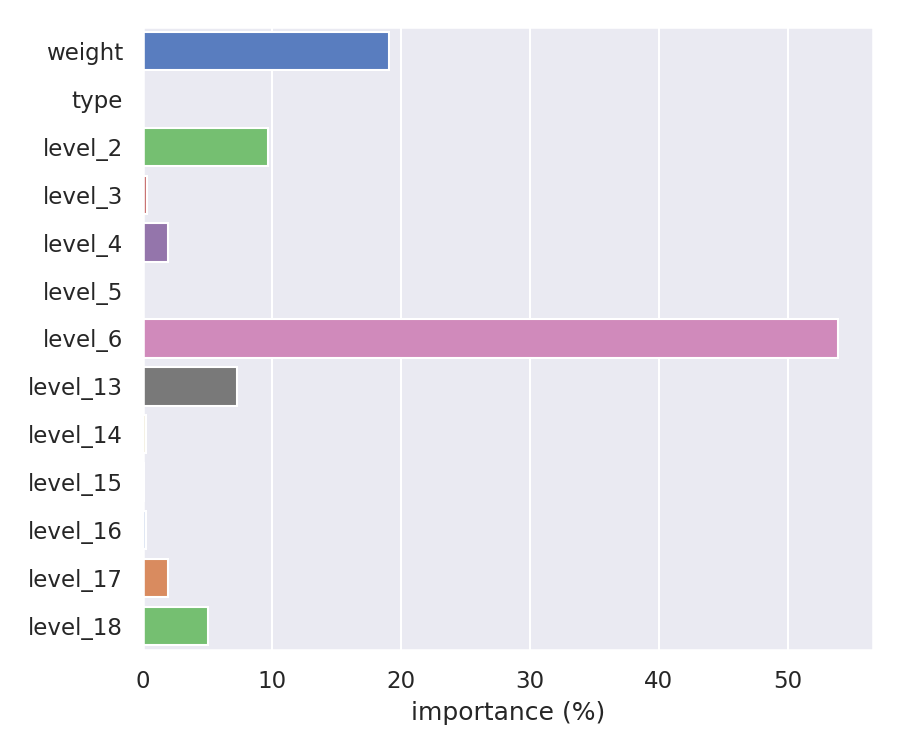

In [38]:
from IPython.display import Image
Image('./img/{}_rank.png'.format(OUTPUT), width=480)

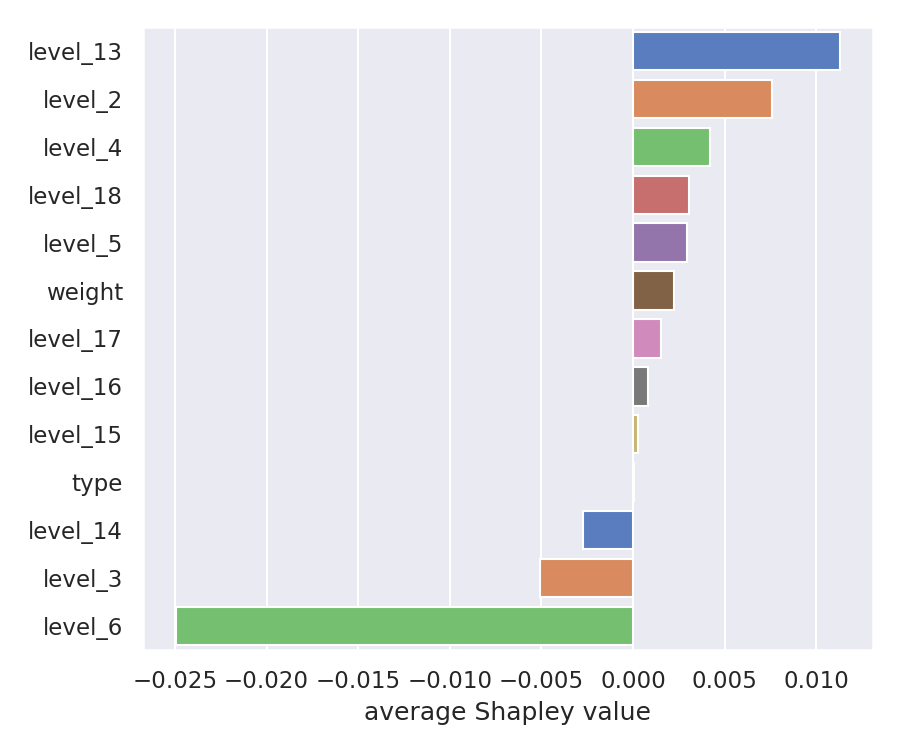

In [39]:
from IPython.display import Image
Image('./img/{}_shap.png'.format(OUTPUT), width=480)

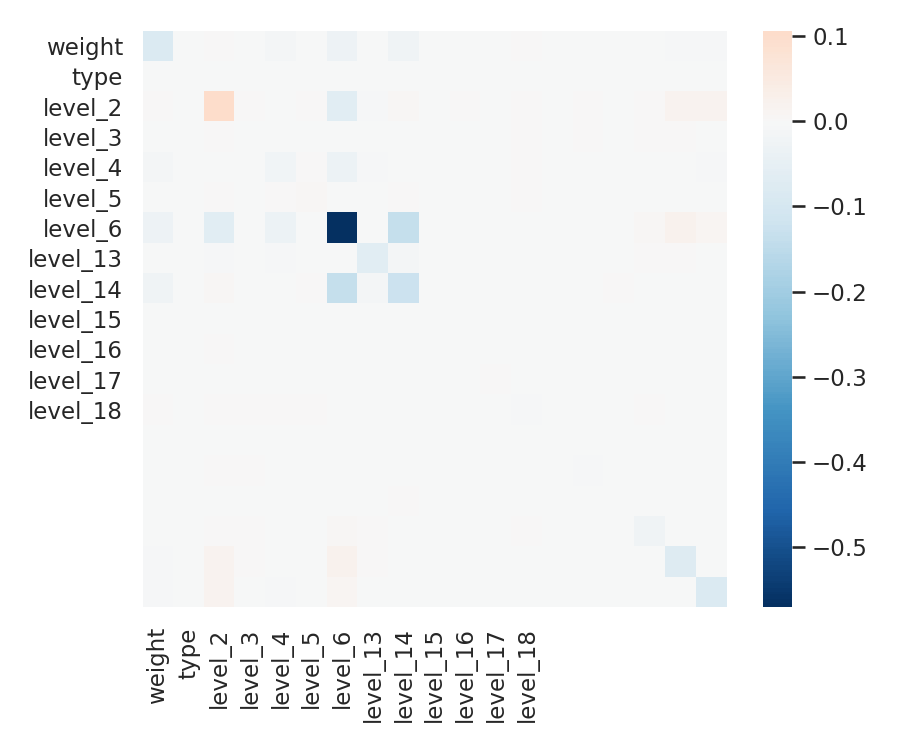

In [40]:
from IPython.display import Image
Image('./img/{}_shap_int.png'.format(OUTPUT), width=480)

### Removing Random Truncation Levels

In [41]:
import pandas as pd
import random

random.seed(123)

# load the datasets
train = pd.read_csv('./data/train.csv')
val   = pd.read_csv('./data/val.csv')
test  = pd.read_csv('./data/test.csv')

# remove the features
col = random.sample(train.filter(regex='^level_.*').columns.tolist(), 6)
train = train.drop(columns=col)
val   = val.drop(columns=col)
test  = test.drop(columns=col)

# join the validation and test sets (do not use optimisation and divide 80/20)
new_test = pd.concat([val, test])

# temporarily save the new datasets
train.to_csv('./data/train_tmp.csv', index=False)
new_test.to_csv('./data/test_tmp.csv', index=False)

# load the labels (join validation and test)
lab_val = pd.read_csv('./data/lab_val.csv')
lab_test = pd.read_csv('./data/lab_test.csv')

new_lab_test = pd.concat([lab_val, lab_test])

new_lab_test.to_csv('./data/lab_test_tmp.csv', index=False)

In [42]:
TRAIN = './data/train_tmp.csv'
TEST  = './data/test_tmp.csv'

LAB_TRAIN = './data/lab_train.csv'
LAB_TEST  = './data/lab_test_tmp.csv'

!cp ./models/gbdt_lgbmregressor.pkl ./models/gbdt_lgbmregressor_shap.pkl
ESTIMATOR = './models/gbdt_lgbmregressor_shap.pkl'

OUTPUT = 'gbdt_no6'

!python3 ./scripts/scikit-train.py -t {TRAIN} -l {LAB_TRAIN} -e {ESTIMATOR}
!python3 ./scripts/scikit-predict.py -t {TEST} -l {LAB_TEST} -e {ESTIMATOR} -o {OUTPUT}

LGBMRegressor trained in 0.115 seconds.
LGBMRegressor predicted in 0.003 seconds.


In [43]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
gbdt_no6,132,0.001839,-0.000265,0.003943,0.042882,0.020906,0.996295


In [44]:
import joblib
import pandas as pd

grd_bst = joblib.load(ESTIMATOR)
test    = pd.read_csv('./data/test_tmp.csv')

# import the "explainers" and save the values
grd_bst_exp = shap.TreeExplainer(grd_bst, feature_perturbation='tree_path_dependent')

# extract the Shapley values
grd_bst_shap = grd_bst_exp.shap_values(test)
joblib.dump(grd_bst_shap, './shap/grd_bst_no6_shap.pkl')

rgrd_bst_int_shap = grd_bst_exp.shap_interaction_values(test)
joblib.dump(grd_bst_int_shap, './shap/grd_bst_no6_int_shap.pkl')

# compute the feature importance
grd_bst_imp = grd_bst.feature_importances_.reshape(-1,)
joblib.dump(grd_bst_imp, './shap/grd_bst_no6_imp.pkl')

# finally store the names of the features
features = list(test.columns)
joblib.dump(features, './shap/feature_no6_list.pkl')

# compute and display the Shapley values
SHAPLEY  = './shap/grd_bst_no6_shap.pkl'
INTERACT = './shap/grd_bst_no6_int_shap.pkl'
RANK     = './shap/grd_bst_no6_imp.pkl'
FEAT     = './shap/feature_no6_list.pkl'
OUTPUT   = 'grd_bst'

!python3 ./scripts/shap.py --features {FEAT} \
                           --shapley {SHAPLEY} \
                           --inter {INTERACT} \
                           --rank {RANK} \
                           --output {OUTPUT}

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


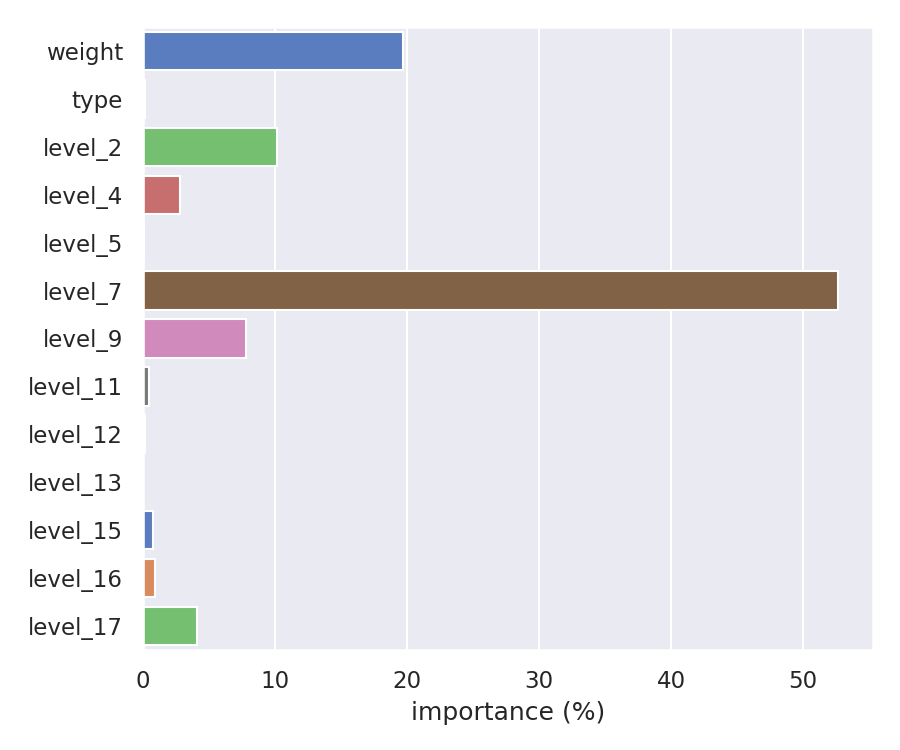

In [45]:
from IPython.display import Image
Image('./img/{}_rank.png'.format(OUTPUT), width=480)

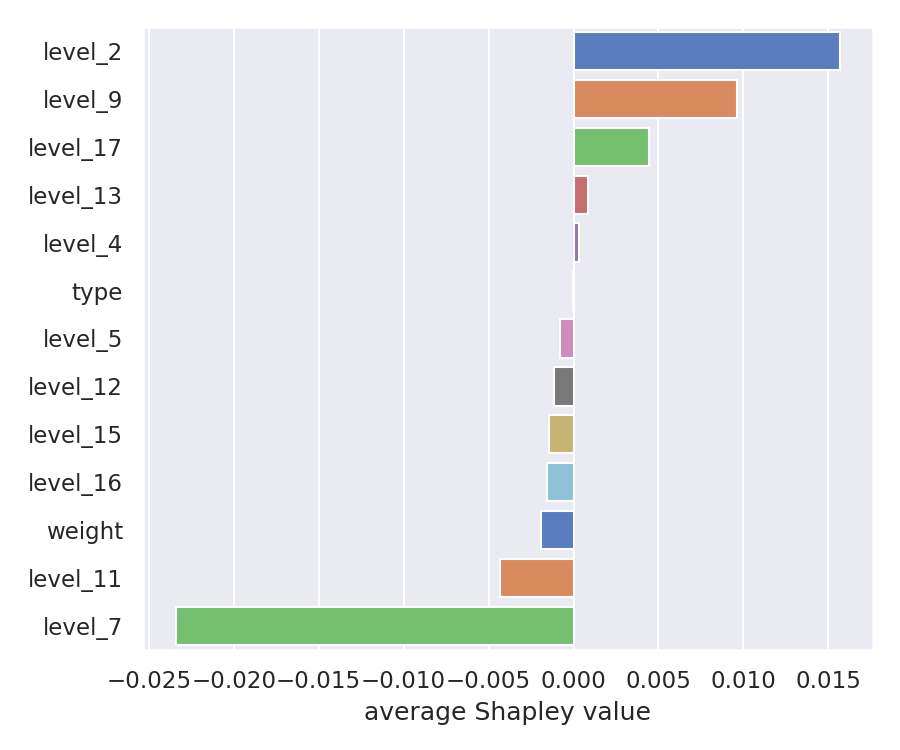

In [46]:
from IPython.display import Image
Image('./img/{}_shap.png'.format(OUTPUT), width=480)

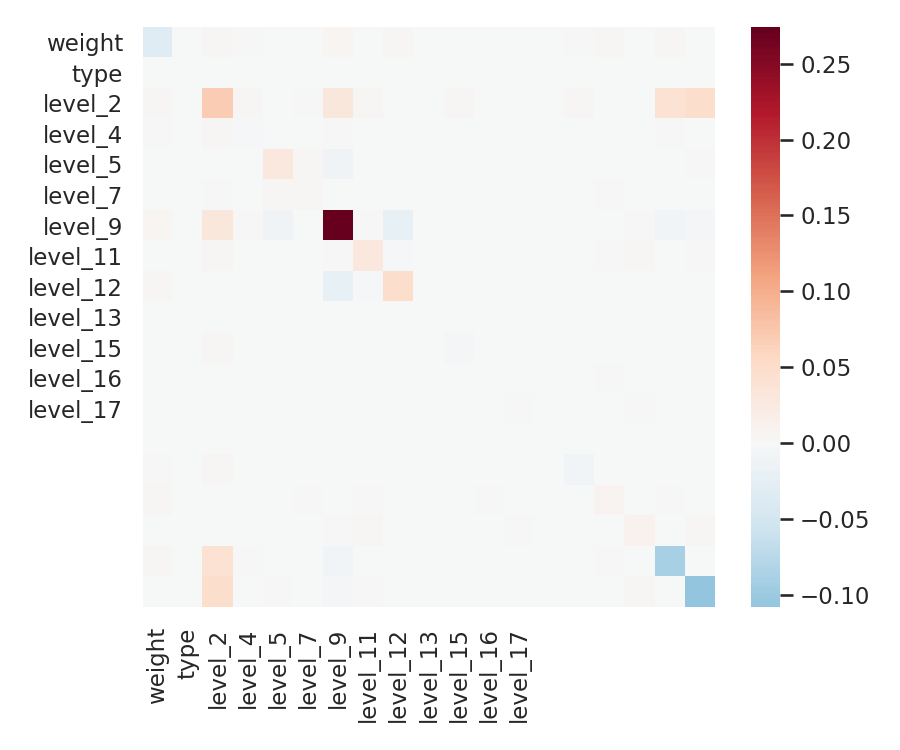

In [47]:
from IPython.display import Image
Image('./img/{}_shap_int.png'.format(OUTPUT), width=480)